### Initialization

In [ ]:
!pip install urizen

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 171.4/171.4 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.9/30.9 MB 22.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 25.0 MB/s eta 0:00:00


In [ ]:
import urizen as uz

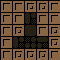

In [ ]:
# M = uz.dungeon_bsp_tree(50, 50)
M = uz.dungeon_drunkard(5, 5)

# And visualize it using Pillow with Urizen tileset
uz.vg_tiled(M, scale=1)

In [ ]:
# Initializing tiles for player and enemy

Map = uz.building_ruined_house(w=9, h=9)
player = Map.cells[0][0]
enemy = Map.cells[0][0]

### Some experimentation with urizen

In [ ]:
from PIL import Image
Map = uz.building_ruined_house(w=9, h=9)
a = uz.vg_tiled(Map, scale=3, show=False, filepath=None)
a.save(fp='name.png', format=None)

In [ ]:
# vars(Map)
# vars(Map.cells[0][0].metatile)
Map.cells[0][0].metatile.get_tiles()
# vars(Map.cells[0][0].metatile.get_tiles()[0])

In [ ]:
uz.core.entity_collection.C.wall_dungeon_smooth

urizen.core.entity_collection.wall_dungeon_smooth

In [ ]:
TILESETS = [
  # 'urizen-onebit-basic',
  # 'urizen-onebit-fantasy-medieval',
  'urizen-onebit-modern',
  # 'urizen-onebit-fonts',
]

for tileset in TILESETS:
  cells, things, actors = uz.core.entity_collection._get_tileset_tiles(tileset)
  uz.core.entity_collection.cell_metatiles.update(cells)
  uz.core.entity_collection.thing_metatiles.update(things)
  uz.core.entity_collection.actor_metatiles.update(actors)

C_attributes = {
    name: type(
        name,
        (uz.core.entity_collection.Cell,),
        {
            #'pixel_color': _get_tileblock_color(cell_metatiles[name]),
            'metatile': uz.core.entity_collection.cell_metatiles[name],
            'tags': uz.core.entity_collection.cell_metatiles[name].tags,
        }
    ) for name in uz.core.entity_collection.cell_metatiles
}

uz.core.entity_collection.C = type('C', (object,), C_attributes)

In [ ]:
# [row][column]
Map.cells[0][0].actors = [Map.cells[1][0]]

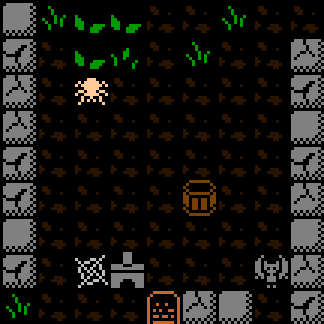

In [ ]:
uz.vg_tiled(Map, scale=3, show=True, filepath=None)


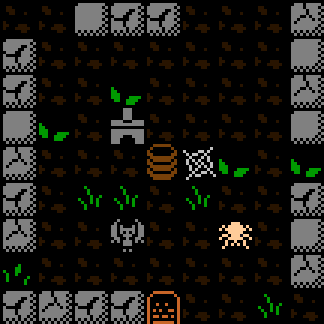

In [ ]:
import io
import numpy as np
import time
import base64
import matplotlib.pyplot as plt
import IPython

def fig2b64(f):
  # data = io.BytesIO()
  # f.savefig(data, format='png')
  # data.seek(0)
  # return base64.b64encode(data.read()).decode()
  # buffered = io.BytesIO()
  # a.save(buffered, format='png')
  # return base64.b64encode(buffered.getvalue())
  data = io.BytesIO()
  a.save(data, format='png')
  data.seek(0)
  return base64.b64encode(data.read()).decode()

f = plt.figure(num=1, clear=True)
x = np.arange(10)
y = np.arange(10)
line = f.gca().plot(x, y)[0]

data_str = fig2b64(f)

IPython.display.display_html(f'<img class="myimage" src="data:image/png;base64,{data_str}"></img>', raw=True)

for _ in range(10):
  time.sleep(0.3)
  np.random.shuffle(y)
  line.set_data(x, y)
  data_str = fig2b64(f)
  IPython.display.display_javascript(f'''
    document.querySelector('.myimage').src = 'data:image/png;base64,{data_str}';
  ''', raw=True)

# suppress final output
plt.close(1)

In [ ]:
# Neural network
# Predict the level you will go to with current equipment
# Advise a player with next steps
# Complete it by itself, like mario, no death

In [ ]:
# player = Map.cells[0][0]
# enemy = Map.cells[0][0]

# p = player_start_coords(M)
# e = enemy_start_coords(M)
# M.cells[p[0]][p[1]].actors = [player]
# M.cells[e[0]][e[1]].actors = [enemy]
# uz.vg_tiled(M, scale=1)

### The game itself

In [ ]:
import io
import numpy as np
import time
import base64
import matplotlib.pyplot as plt
import IPython

class Painter:
  def _fig2b64(self, img):
    data = io.BytesIO()
    img.save(data, format='png')
    data.seek(0)
    return base64.b64encode(data.read()).decode()

  def draw_init(self, img):
    data_str = self._fig2b64(img)
    IPython.display.display_html(f'<img class="myimage" src="data:image/png;base64,{data_str}"></img>', raw=True)

  def draw_step(self, img):
    data_str = self._fig2b64(img)
    IPython.display.display_javascript(f'''
        document.querySelector('.myimage').src = 'data:image/png;base64,{data_str}';
    ''', raw=True)

In [ ]:
from copy import copy, deepcopy

class Game:
  def __init__(self, map):
    self.map = map
    self.p = self._player_start_coords(map)
    self.e = self._enemy_start_coords(map)
    self._convert_to_array()
    self.n_steps = 0
    self.action_space = np.arange(4)

  def _convert_to_array(self):
    self.arr = []
    for y in range(len(self.map.cells)):
      self.arr.append([])
      for x in range(len(self.map.cells[y])):
        self.arr[y].append(1 if 'wall' in self.map.cells[y][x].metatile.tags else 0)

  def _place_on_map(self):
    new_arr = deepcopy(self.arr)
    new_arr[self.p[0]][self.p[1]] = 500
    new_arr[self.e[0]][self.e[1]] = 999
    return np.array(new_arr, dtype='float32')

  def reset(self):
    self.p = self._player_start_coords(self.map)
    self.e = self._enemy_start_coords(self.map)
    self._convert_to_array()
    self.n_steps = 0
    return self._place_on_map()

  def _player_start_coords(self, m):
    for y in range(len(m.cells) - 1, -1, -1):
      for x in range(len(m.cells[y])):
        if 'floor' in m.cells[y][x].metatile.tags:
          return [y, x]

  def _enemy_start_coords(self, m):
    for y in range(len(m.cells)):
      for x in range(len(m.cells[y]) - 1, -1, -1):
        if 'floor' in m.cells[y][x].metatile.tags:
          return [y, x]

  def _manh_dist(self, p1, p2):
    return abs(p1[0] - p2[0]) + abs(p1[1] - p2[1])

  def step(self, move):
    # move:
    # 0 - up
    # 1 - down
    # 2 - left
    # 3 - right

    reward = 0
    done = False

    prev = self.p.copy()

    if move == 0:
      if self.arr[self.p[0] - 1][self.p[1]] == 0:
        self.p[0] -= 1
    elif move == 1:
      if self.arr[self.p[0] + 1][self.p[1]] == 0:
        self.p[0] += 1
    elif move == 2:
      if self.arr[self.p[0]][self.p[1] - 1] == 0:
        self.p[1] -= 1
    elif move == 3:
      if self.arr[self.p[0]][self.p[1] + 1] == 0:
        self.p[1] += 1

    if self.p[0] == self.e[0] and self.p[1] == self.e[1]:
      reward = 1000
      done = True
    else:
      reward = self._manh_dist(prev, self.e) - self._manh_dist(self.p, self.e)

    self.n_steps += 1

    return self._place_on_map(), reward, done

  def render_image(self):
    self.map.cells[self.p[0]][self.p[1]].actors = [player]
    self.map.cells[self.e[0]][self.e[1]].actors = [enemy]
    render = uz.vg_tiled(self.map, scale=2, show=False, filepath=None)

    self.map.cells[self.p[0]][self.p[1]].actors = []
    self.map.cells[self.e[0]][self.e[1]].actors = []

    return render

  def close(self):
    print('game ended')

### Try 1 - with no knowledge and ChatGPT

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten
from tensorflow.keras.optimizers import Adam
import random
from collections import deque

# Hyperparameters
state_size = (M.h, M.w)  # Example state size
action_size = 4  # Up, Down, Left, Right
batch_size = 32
gamma = 0.99  # Discount factor
epsilon = 1.0  # Exploration rate
epsilon_min = 0.1
epsilon_decay = 0.995
# epsilon_decay = 1
learning_rate = 0.01
episodes = 2

# Define the Q-network
def build_model():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=state_size + (1,)),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(action_size, activation='linear')
    ])
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse')
    return model

# Define the replay buffer
class ReplayBuffer:
    def __init__(self, max_size):
        self.buffer = deque(maxlen=max_size)

    def add(self, experience):
        self.buffer.append(experience)

    def sample(self, batch_size):
        return random.sample(self.buffer, batch_size)

env = Game(M)

painter = Painter()
painter.draw_init(env.render_image())

# Initialize replay buffer and Q-network
replay_buffer = ReplayBuffer(max_size=2000)
model = build_model()

# Training loop
for episode in range(episodes):
    state = env.reset()
    state = np.reshape(state, [1] + list(state_size))
    done = False
    total_reward = 0

    while not done:
        # Choose action
        if np.random.rand() <= epsilon:
            action = np.random.choice(action_size)
        else:
            # print('my chose')
            q_values = model.predict(state, verbose=0)
            action = np.argmax(q_values[0])

        # Take action
        next_state, reward, done, _ = env.step(action)
        next_state = np.reshape(next_state, [1] + list(state_size))
        # print(action)
        # print(env.p[0], env.p[1])

        painter.draw_step(env.render_image())

        # Store experience
        replay_buffer.add((state, action, reward, next_state, done))

        # Update state
        state = next_state
        total_reward += reward

        if len(replay_buffer.buffer) > batch_size:
            minibatch = replay_buffer.sample(batch_size)
            states = np.vstack([s[0] for s in minibatch])
            actions = np.array([s[1] for s in minibatch])
            rewards = np.array([s[2] for s in minibatch])
            next_states = np.vstack([s[3] for s in minibatch])
            dones = np.array([s[4] for s in minibatch])

            # Predict Q-values for next states in batch
            q_next = model.predict(next_states, verbose=0)
            q_targets = rewards + gamma * np.amax(q_next, axis=1) * (1 - dones)

            # Predict Q-values for current states in batch
            q_values = model.predict(states, verbose=0)
            for i in range(batch_size):
                q_values[i][actions[i]] = q_targets[i]

            # Train the model
            model.fit(states, q_values, epochs=1, verbose=0)

        # Decrease epsilon
        if epsilon > epsilon_min:
            epsilon *= epsilon_decay

    print(f"Episode {episode + 1}/{episodes}, Total Reward: {total_reward}")

env.close()


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten
from tensorflow.keras.optimizers import Adam
import random
from collections import deque
import keras
from keras import ops

# Hyperparameters
state_size = (M.h, M.w)  # Example state size
action_size = 4  # Up, Down, Left, Right
# epsilon_decay = 1
learning_rate = 0.01
episodes = 10

# Define the Q-network
def build_model():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=state_size + (1,)),
        Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=state_size + (1,)),
        Conv2D(128, (3, 3), activation='relu', padding='same', input_shape=state_size + (1,)),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(32, activation='relu'),
        Dense(action_size, activation='softmax')
    ])
    # model.compile(optimizer=Adam(learning_rate=learning_rate), loss='binary_crossentropy')
    return model

env = Game(M)

painter = Painter()
painter.draw_init(env.render_image())

model = build_model()
optimizer = keras.optimizers.Adam(learning_rate=0.01)

# Training loop
for episode in range(episodes):
    state = env.reset()
    state = np.reshape(state, [1] + list(state_size))
    done = False

    timestamp = 0
    action_probs_history = []
    rewards_history = []

    with tf.GradientTape() as tape:

        while not done and timestamp < 50:
            # Choose action
            action_probs = model(state)
            # action = np.random.choice(action_size, p=np.squeeze(action_probs))
            action = np.random.choice(action_size)
            # print(pred)
            action_probs_history.append(action_probs[0, action])

            # Take action
            next_state, reward, done, _ = env.step(action)
            next_state = np.reshape(next_state, [1] + list(state_size))
            reward = 1000 - reward
            rewards_history.append(reward)
            # print(f"Action: {action}")
            # print(f"Position: ({env.p[0]}, {env.p[1]})")
            # print(f"Reward: {reward}")

            painter.draw_step(env.render_image())

            timestamp += 1

        # Apply gradients
        loss_value = ops.dot(action_probs_history, tf.dtypes.cast(rewards_history, tf.float32))
        # print(loss_value)
        grads = tape.gradient(loss_value, model.trainable_variables)
        # print(grads)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))


    print(f"Episode {episode + 1}/{episodes}")

env.close()


In [ ]:
import time

painter = Painter()
painter.draw_init(env.render_image())

for episode in range(episodes):
    state = env.reset()
    state = np.reshape(state, [1] + list(state_size))
    done = False

    timestamp = 0
    action_probs_history = []
    rewards_history = []

    while not done and timestamp < 50:
        # Choose action
        action_probs = model.predict(state, verbose=0)
        action = np.random.choice(action_size, p=np.squeeze(action_probs))
        # print(pred)
        action_probs_history.append(action_probs[0, action])

        # Take action
        next_state, reward, done, _ = env.step(action)
        next_state = np.reshape(next_state, [1] + list(state_size))
        reward = reward
        rewards_history.append(reward)
        print(f"Action: {action}")
        # print(f"Position: ({env.p[0]}, {env.p[1]})")
        # print(f"Reward: {reward}")

        painter.draw_step(env.render_image())

        timestamp += 1

        # time.sleep(0.5)

    print(f"Episode {episode + 1}/{episodes}")

### Try 2 - with some knowledge about Q-Learning (+Deep)

In [ ]:
import numpy as np
import copy
import torch
from torch import nn
import torch.nn.functional as F
from tqdm import tqdm

In [ ]:
def move_one_hot(move):
  arr = np.zeros(4, dtype='float32')
  arr[move] = 1
  return arr

In [ ]:
class SimpleConv(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(1, 16, 3, padding=1)
    self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
    self.globalavgpool = nn.AvgPool2d(5)
    self.fc1 = nn.Linear(32, 4)
    self.fc2 = nn.Linear(8, 1)
    # self.fc3 = nn.Linear(64, 1)

  def forward(self, input):
    # state is a 2d numpy array
    # action is a number
    state, action = input
    state = torch.from_numpy(state[np.newaxis, :])
    action = torch.from_numpy(move_one_hot(action))

    x = state
    x = F.relu(self.conv1(x))
    x = F.relu(self.conv2(x))
    x = F.relu(self.globalavgpool(x))
    x = torch.flatten(x)
    x = F.relu(self.fc1(x))
    x = F.normalize(x, dim=0)
    x = torch.concatenate((x, action))
    # x = F.relu(self.fc2(x))
    x = self.fc2(x)
    return x

def smoke_test():
  torch.manual_seed(42)
  a = np.float32(np.random.rand(5, 5))
  model = SimpleConv()
  print(model((a, 1)))
  print(model((a, 2)))

smoke_test()

tensor([-0.0384], grad_fn=<ViewBackward0>)
tensor([-0.7259], grad_fn=<ViewBackward0>)


In [ ]:
env = Game(M)

In [ ]:
torch.manual_seed(42)
num_iterations = 1000
replay_buffer = []
p_random_choice = 0.3 # probability to do exploration # AAAAAAAAAAAA
model = SimpleConv()
prev_model = deepcopy(model)
optimizer = torch.optim.SGD(params = model.parameters(), lr = 0.001)
num_minibatch = 50
future_importance = 1 # TODO: NOT SURE WHAT VALUE THIS CONSTANT SHOULD HAVE
model_update_steps = 50 # TODO: NOT SURE WHAT VALUE THIS CONSTANT SHOULD HAVE

observation = env.reset()

with torch.no_grad():
  for iteration in tqdm(range(num_iterations)):
    # Sampling phase
    if np.random.rand() < p_random_choice:
      action = np.random.choice(env.action_space)
    else:
      action = np.argmax([model((observation, action_variant)) for action_variant in env.action_space])
      action = 3
      # TODO: SOMEWHY FOR EACH ACTION PROVIDES FROM MODEL EQUAL RETURN
      # TODO: AND AFTER SOME TIME ALL VALUES ARE DECAYING TO FREAKING ZERO
      # TODO: MAYBE ITS BECAUSE  I USE ENCODING 0 1 2 3 FOR ACTIONS, WHICH IS BAD?
      # TODO: MAYBE I SHOULD USE CLASSIFICATION TECHNIQUE OR ONE-HOT ENCODING?
    prev_observation = observation
    observation, reward, terminated = env.step(action)
    if reward != 0:
      replay_buffer.append((prev_observation, action, reward, observation, terminated))

    # Training phase
    # if len(replay_buffer) < num_minibatch:
    #   continue

    replay_indices = np.random.choice(len(replay_buffer), min(num_minibatch, len(replay_buffer)))
    for i_replay in replay_indices:
      sample = replay_buffer[i_replay]
      if sample[4]: # If last transition
        y_true = sample[2]
      else:
        # The error was here.
        # I calculated q_value_true using initial observation from sample,
        # but it should have been the next observation, so it will connect future rewards
        # and proagate them back to this state from the very end.
        q_value_true = max([prev_model((sample[3], action_variant)) for action_variant in env.action_space])
        y_true = sample[2] + future_importance * q_value_true
        # print([prev_model((sample[3], action_variant)) for action_variant in env.action_space])
        # print(q_value_true)
        # print(y_true)
      # Gradient descent step
      with torch.enable_grad():
        # print('GRADIENT DESCENT STEP')
        # print([model((sample[0], action_variant)) for action_variant in env.action_space])
        # print(y_true)
        # print(model((sample[0], sample[1])))
        loss = (y_true - model((sample[0], sample[1]))) ** 2
        optimizer.zero_grad()
        loss.backward()
        # print(model.fc2.weight.grad)
        optimizer.step()
        # print([model((sample[0], action_variant)) for action_variant in env.action_space])
        # raise KeyboardInterrupt
        # CONCLUSION, GRADINT DOESN'T STAY THE SAME, IT'S JUST SOMEWHY THE ACTION (0 1 2 3) IS NOT CONSIDERED IMPORTANT.
        # AT LEAST, LOOKS LIKE THIS.
        # NO. SOMEWHY. ITHAS GIVEN HIGH WEIGHT TO ACTION "DOWN". (1). 8.4726e+01
        # Parameter containing:
        # tensor([[-2.5610e-01,  4.4061e+02, -2.8168e-01, -1.7306e-01,  1.2421e+02,
        # 8.4726e+01,  1.1643e+02,  1.1491e+02]], requires_grad=True)
    if iteration % model_update_steps == model_update_steps - 1:
      prev_model = deepcopy(model)

    # Reset
    if terminated:
      observation = env.reset()

print()
env.close()

100%|██████████| 1000/1000 [02:19<00:00,  7.18it/s]


game ended


In [ ]:
model.fc2.weight

Parameter containing:
tensor([[-2.5610e-01,  4.4061e+02, -2.8168e-01, -1.7306e-01,  1.2421e+02,
          8.4726e+01,  1.1643e+02,  1.1491e+02]], requires_grad=True)


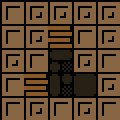

reward: 0


reward: 0


reward: 0


reward: 0


KeyboardInterrupt: 

In [ ]:
import time

observation = env.reset()

painter = Painter()
painter.draw_init(env.render_image())

n_fallen = 0
with torch.no_grad():
  for iteration in range(100):
    action = np.argmax([model((observation, action_variant)) for action_variant in env.action_space])
    # action = 3
    observation, reward, terminated = env.step(action)
    print(f'reward: {reward}')
    painter.draw_step(env.render_image())
    time.sleep(1)

    if terminated:
      observation = env.reset()

env.close()